# Dinitz's algorithm and its applications
In this notebook, we will introduce the [Maximum flow problem](https://en.wikipedia.org/wiki/Maximum_flow_problem)
and [Dinitz's algorithm](https://en.wikipedia.org/wiki/Dinic%27s_algorithm) [^1], which is implemented at
[algorithms/flow/dinitz_alg.py](https://github.com/networkx/networkx/blob/main/networkx/algorithms/flow/dinitz_alg.py)
in NetworkX. We will also see how it can be used to solve some interesting problems.

## Maximum flow problem

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import PIL
import math
from copy import deepcopy
from collections import deque

### Motivation
Let's say you want to send your friend some data as soon as possible, but the only way
of communication/sending data between you two is through a peer-to-peer network. An
interesting thing about this peer-to-peer network is that it allows you to send data
along the paths you specify with certain limits on the sizes of data per second that
you can send between a pair of nodes in this network.

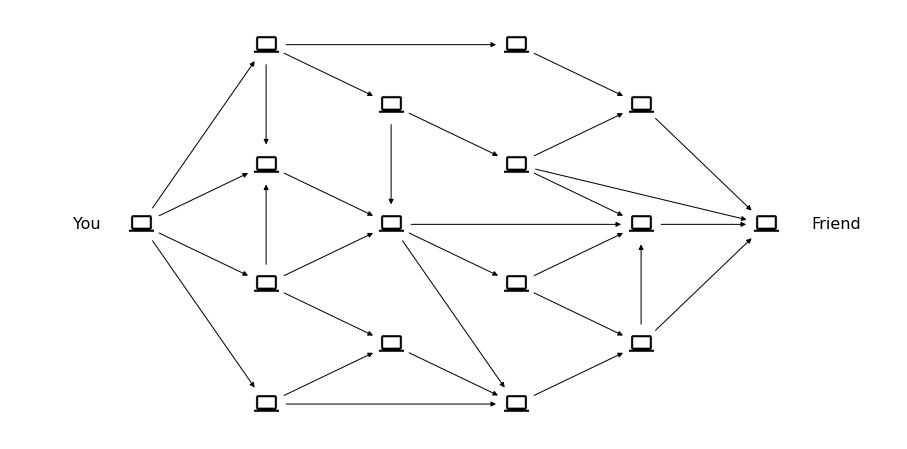

In [2]:
# Load the example graph
G = nx.read_gml("data/example_graph.gml")
# Extract info about node position from graph (for visualization)
pos = {k: np.asarray(v) for k, v in G.nodes(data="pos")}
label_pos = deepcopy(pos)
label_pos["s"][0] = -1.15
label_pos["t"][0] = 1.20
labels = {"s": "You", "t": "Friend"}

fig, ax = plt.subplots(figsize=(16, 8))
nx.draw_networkx_edges(G, pos=pos, ax=ax, min_source_margin=20, min_target_margin=20)
nx.draw_networkx_labels(G, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4])
ax.axis("off")

# Spruce up the image with computer icons to represent the nodes
tr_figure = ax.transData.transform
tr_axes = fig.transFigure.inverted().transform
icon_size = abs(np.diff(ax.get_xlim())) * 0.015
icon_center = icon_size / 2
icon = PIL.Image.open("images/computer_black_144x144.png")
for n in G.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(icon)
    a.axis("off")

So how shall you plan the paths of the data packets to send them in the least amount
of time?

Note that here we can divide the data into small data packets and send it across the
network and the receiver will be able to rearrange the data packets to reconstruct
the original data.

### Formalization
So how can we model this problem in terms of graphs?

Let's say $N=(V, E)$ represents this peer-to-peer network with $V$ as the set of nodes
where nodes are computers and $E$ as the set of edges where edge $uv \in E$ if there is
a connection from node $u$ to node $v$ across which we can send data. There are also
2 special nodes, the first one is you (node $s$) and the second one is your friend (node $t$). We also name them the ***source*** and ***sink*** nodes respectively.

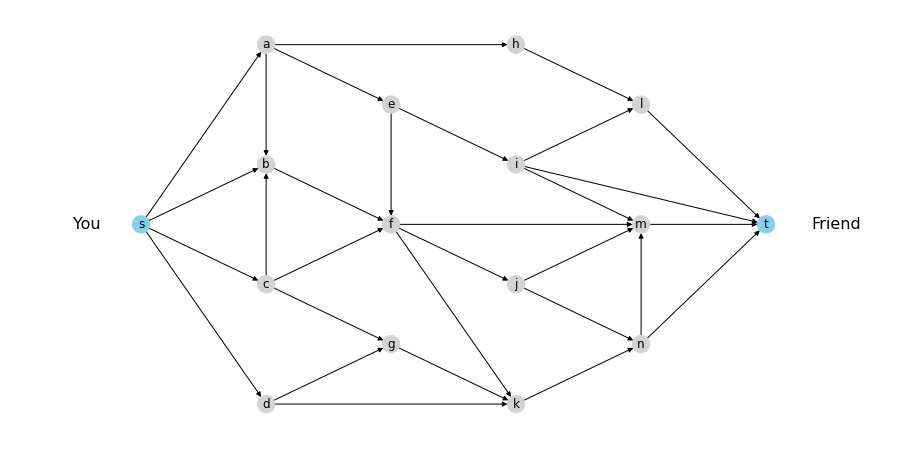

In [3]:
fig, ax = plt.subplots(figsize=(16, 8))

node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in G.nodes]

nx.draw(G, pos, ax=ax, node_color=node_colors, with_labels=True)
nx.draw_networkx_labels(G, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4]);

Now say that node $u$ and node $v$ are connected and the maximum data per second that
you can send from node $u$ to node $v$ is $c_{uv}$, lets call this as capacity of the edge $uv$.

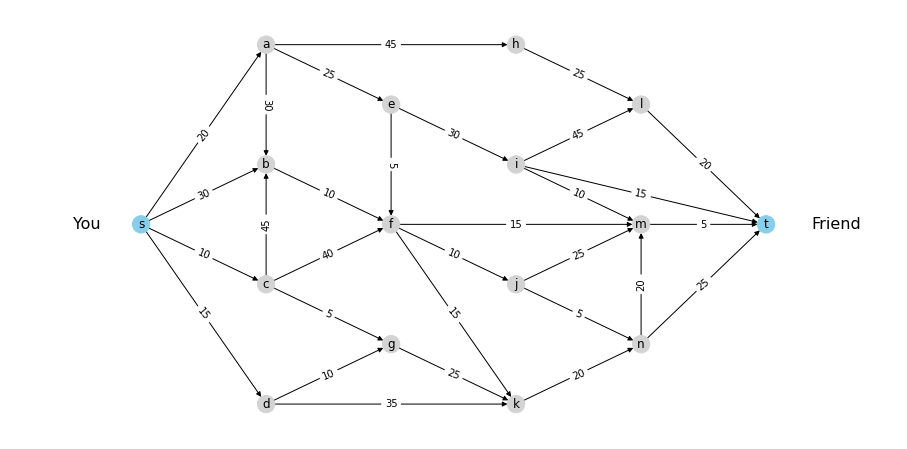

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))

capacities = {(u, v): c for u, v, c in G.edges(data="capacity")}

nx.draw(G, pos, ax=ax, node_color=node_colors, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=capacities, ax=ax)
nx.draw_networkx_labels(G, label_pos, labels=labels, ax=ax, font_size=16)
ax.set_xlim([-1.4, 1.4]);

So before go ahead and plan the paths on which we will be sending the data packets,
we need some way to represent or plan on the network. Observe that any plan will have
to take up some capacity of the edges, so we can represent the plan by the values of
the capacity taken by it for each edge in E, let's call the plan as **flow**. Formally,
we can define flow as $f: E \to \mathbb{R}$ i.e. a mapping from edges $E$ to real numbers
denoting that we are sending data at rate $f(uv)$ through edge $uv\in E$.

Note that for this plan to be a valid plan it must satisfy the following constraints
* **Capacity constraint:**
    The data rate at which we are sending data from any node shouldn't exceed its
    capacity, formally $f_{uv} \le c_{uv}$
* **Conservation of flow:**
    Rate at which data is sent to a node is same as the rate at which the node is sending
    data to other nodes, except for the source $s$ and sink $t$ nodes. Formally
    $\sum\limits_{u|(u,v) \in E}f_{u,v} = \sum\limits_{w|(v,w) \in E}f_{v,w} $ for
    $v\in V\backslash \{s,t\}$

In [5]:
def check_valid_flow(G, flow, source_node, target_node):
    H = nx.DiGraph()
    H.add_edges_from(flow.keys())

    for (u, v), f in flow.items():
        capacity = G[u][v]["capacity"]
        H[u][v]["label"] = f"{f}/{capacity}"
        # Capacity constraint
        if f > G[u][v]["capacity"]:
            H[u][v]["edgecolor"] = "red"
            print(f"Invalid flow: capacity constraint violated for edge ({u!r}, {v!r})")
        # Conservation of flow
        if v not in {source_node, target_node}:
            incoming_flow = sum(
                flow[(i, v)] if (i, v) in flow else 0 for i in G.predecessors(v)
            )
            outgoing_flow = sum(
                flow[(v, o)] if (v, o) in flow else 0 for o in G.successors(v)
            )
            if not math.isclose(incoming_flow, outgoing_flow):
                print(f"Invalid flow: flow conservation violated at node {v}")
                H.nodes[v]["color"] = "red"
    return H


def visualize_flow(flow_graph):
    """Visualize flow returned by the `check_valid_flow` funcion."""
    fig, ax = plt.subplots(figsize=(15, 9))
    
    # Draw the full graph for reference
    nx.draw(G, pos, ax=ax, node_color=node_colors, edge_color="lightgrey", with_labels=True)
    
    # Draw the example flow on top
    flow_nc = [
        "skyblue" if n in {"s", "t"} else flow_graph.nodes[n].get("color", "lightgrey")
        for n in flow_graph
    ]
    flow_ec = [flow_graph[u][v].get("edgecolor", "black") for u, v in flow_graph.edges]
    edge_labels = {(u, v): lbl for u, v, lbl in flow_graph.edges(data="label")}
    nx.draw(flow_graph, pos, ax=ax, node_color=flow_nc, edge_color=flow_ec)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax);

example of valid flow:

In [6]:
example_flow = {
    ("s", "a"): 20,
    ("a", "e"): 15,
    ("e", "i"): 15,
    ("i", "t"): 15,
    ("a", "h"): 5,
    ("h", "l"): 5,
    ("l", "t"): 5,
}

flow_graph = check_valid_flow(G, example_flow, "s", "t")

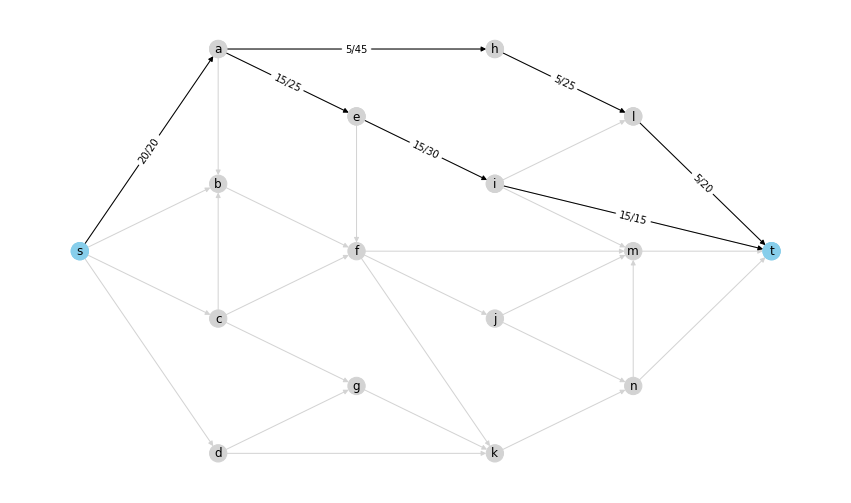

In [7]:
visualize_flow(flow_graph)

example of invalid flow:

In [8]:
example_flow = {
    ("s", "a"): 30,
    ("a", "e"): 25,
    ("e", "i"): 15,
    ("i", "t"): 15,
    ("a", "h"): 5,
    ("h", "l"): 5,
    ("l", "t"): 5,
}

flow_graph = check_valid_flow(G, example_flow, "s", "t")

Invalid flow: capacity constraint violated for edge ('s', 'a')
Invalid flow: flow conservation violated at node e


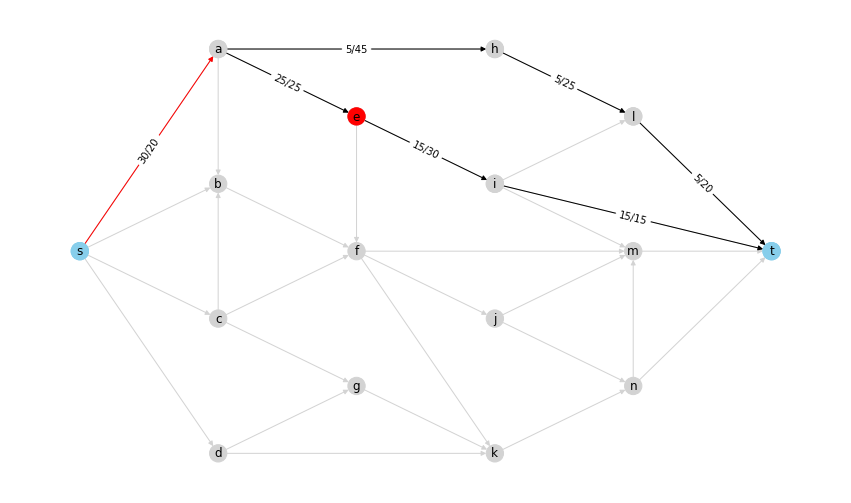

In [9]:
visualize_flow(flow_graph)

red color edges dont satisfy capacity constraint and red color nodes dont satisfy the
conservation of flow

*So if we use this plan/flow to send data then at what rate will we be sending the data to friend?*

To answer this we need to observe that any data that the sink node $t$ will receive will be
from its neighbors so if we sum over the data rates from plan/flow from those neighbors to
the sink node we shall get the total data rate at which $t$ will be receiving the data.
Formally we can say that the **value of the flow** is $|f|=\sum\limits_{u|(u,t) \in E}f_{u,t}$.
Also note that since flow is conservative $|f|$ would also be equal to $\sum\limits_{u|(s,u) \in E}f_{s,u}$.

Remember our goal was to maximize the rate at which the data is being sent to our friend,
which is the same as maximizing the flow value $|f|$.

This is the definition of the **Maximum Flow Problem**.

## Dinitz's algorithm

Before understanding how Dinitz's algorithm works and its steps let's define some terms.

### Residual Capacity & Graph
If we send $f_{uv}$ flow through edge $uv$ with capacity $c_{uv}$, then we define residual
capacity by $g_{uv}=c_{uv}-f_{uv}$ and residual network by $N'$ which only considers the
edges of $N$ if they have non-zero residual capacity.

In [10]:
def residual_graph(G, flow):
    H = G.copy()
    for (u, v), f in flow.items():
        capacity = G[u][v]["capacity"]
        if f > G[u][v]["capacity"]:
            raise ValueError(
                f"Flow {f} exceeds the capacity of edge {u!r}->{v!r}."
            )
        H[u][v]["capacity"] -= f
        if H.has_edge(v, u):
            H[v][u]["capacity"] += f
        else:
            H.add_edge(v, u, capacity=f, etype="rev")
    return H


def draw_residual_graph(R, ax=None):
    """Visualize residual graph returned by `residual_graph`."""
    if not ax:
        fig, ax = plt.subplots(figsize=(15, 9))
        ax.axis("off")

    # Draw nodes
    nx.draw_networkx_nodes(R, pos, node_color=node_colors)
    nx.draw_networkx_labels(R, pos)

    # Categorize edges by their capacity and whether they were added by
    # residual_graph
    orig_edges, zero_edges, rev_edges = [], [], []
    for u, v, data in R.edges(data=True):
        if data.get("etype") == "rev":
            rev_edges.append((u, v))
        elif data["capacity"] == 0:
            zero_edges.append((u, v))
        else:
            orig_edges.append((u, v))

    # Draw edges
    nx.draw_networkx_edges(R, pos, edgelist=orig_edges)
    nx.draw_networkx_edges(
        R, pos, edgelist=rev_edges, edge_color="goldenrod", connectionstyle="arc3,rad=0.2"
    )
    nx.draw_networkx_edges(R, pos, edgelist=zero_edges, style="--", edge_color="lightgrey")
    
    # Label edges by capacity
    rv = set(rev_edges)
    fwd_caps = {
        (u, v): c for u, v, c in R.edges(data="capacity") if (u, v) not in rv
    }
    rev_caps = {
        (u, v): c for u, v, c in R.edges(data="capacity") if (u, v) in rv
    }
    nx.draw_networkx_edge_labels(R, pos, edge_labels=fwd_caps, label_pos=0.667)
    nx.draw_networkx_edge_labels(
        R, pos, edge_labels=rev_caps, label_pos=0.667, font_color="goldenrod"
    )

example flow:

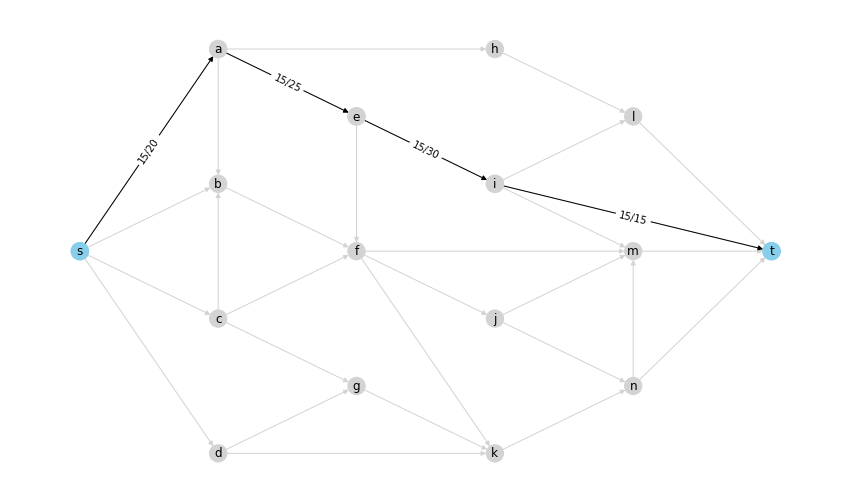

In [11]:
example_flow = {
    ("s", "a"): 15,
    ("a", "e"): 15,
    ("e", "i"): 15,
    ("i", "t"): 15,
}

visualize_flow(check_valid_flow(G, example_flow, "s", "t"))

This is the residual network for the flow shown above:

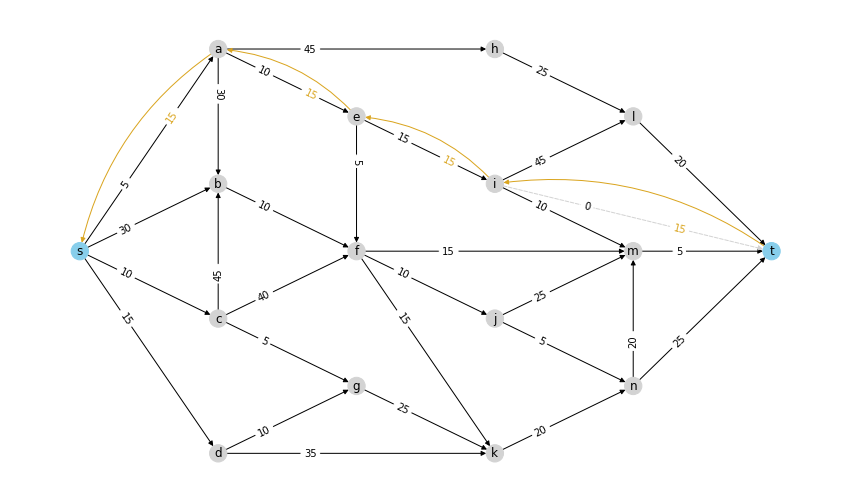

In [12]:
R = residual_graph(G, example_flow)
draw_residual_graph(R)

Note: In residual network we consider both the $uv$ and $vu$ edges if any of them is in $N$
### Level Network

The level network is a subgraph of the residual network which we get when we apply
[BFS](https://en.wikipedia.org/wiki/Breadth-first_search) from source node $s$
considering only the edges for which we have $c_{uv}-f_{uv}>0$ in the residual network
and divide the nodes into levels then we only consider the edges to be in the level
network $L$ which connect nodes of 2 different levels

In [13]:
# Mapping between node level and color for visualization
level_colors = {
    1:'aqua', 2:'lightgreen', 3:'yellow', 4:'orange', 5:'lightpink', 6:'violet'
}

def level_bfs(R, flow, source_node, target_node):
    """BFS to construct the level network from residual network for given flow."""
    parents, level = {}, {}
    queue = deque([source_node])
    level[source_node] = 0
    while queue:
        if target_node in parents:
            break
        u = queue.popleft()
        for v in R.successors(u):
            if (v not in parents) and (R[u][v]["capacity"] > 0):
                parents[v] = u
                level[v] = level[u] + 1
                queue.append(v)
    return parents, level


def draw_level_network(R, parents, level, background=False):
    fig, ax = plt.subplots(figsize=(15, 9))
    ax.axis("off")

    # Draw nodes
    nodelist = list(level.keys())
    if background:
        level_nc = "lightgrey"
    else:
        level_nc = [level_colors[l] for l in level.values()]
        level_nc[0] = level_nc[-1] = "skyblue"
    nx.draw_networkx_nodes(R, pos, nodelist=nodelist, node_color=level_nc)
    if not background:
        nx.draw_networkx_labels(R, pos)

    # Draw edges
    fwd_edges = [(v, u) for u, v in parents.items() if (v, u) in G.edges]
    labels = {(u, v): R[u][v]["capacity"] for u, v in fwd_edges}
    ec = "lightgrey" if background else "black"
    nx.draw_networkx_edges(R, pos, edgelist=fwd_edges, edge_color=ec)
    if not background:
        nx.draw_networkx_edge_labels(R, pos, edge_labels=labels, label_pos=0.667)

    rev_edges = [(v, u) for u, v in parents.items() if (v, u) not in G.edges]
    labels = {(u, v): R[u][v]["capacity"] for u, v in rev_edges}
    ec = "lightgrey" if background else "goldenrod"
    nx.draw_networkx_edges(
        R, pos, edgelist=rev_edges, connectionstyle="arc3,rad=0.2", edge_color=ec
    )
    if not background:
        nx.draw_networkx_edge_labels(
            R, pos, edge_labels=labels, label_pos=0.667, font_color="goldenrod"
        )

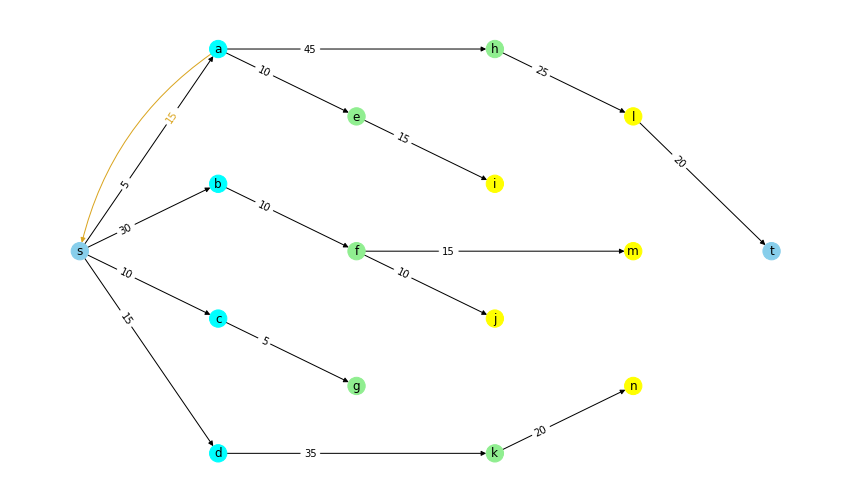

In [14]:
parents, level = level_bfs(R, example_flow, "s", "t")
draw_level_network(R, parents, level)

Note that if sink node $t$ is not reachable from the source node $s$ that means that no
more flow can be pushed through the residual network.

### Augmenting Path & Flow

An *augmenting path* $P$ is a path from source node $s$ to sink node $t$ such that all
the edges on the path have positive residual capacity i.e. $g_{uv}>0$ for $uv \in P$.
An *augmenting flow* $\alpha$ for the path $P$ is the minimum value of the residual
flow across all the edges of $P$. i.e. $\alpha = min\{g_{uv}, uv \in P\}$.

And by augmenting the flow along path $P$ we mean that reduce the residual capacities
of the edges in path $P$ by $\alpha$ which will leave at least one of the edges on the
residual network with zero residual capacity.

We find augmenting paths by applying [DFS](https://en.wikipedia.org/wiki/Depth-first_search)
on the Level network $L$.

In [15]:
def aug_path_dfs(parents, flow, source_node, target_node):
    """Build a path using DFS starting from the target_node"""
    path = []
    u = target_node
    f = 3 * max(flow.values())  # Initialize flow to large value
    while u != source_node:
        path.append(u)
        v = parents[u]
        f = min(f, R.pred[u][v]["capacity"] - flow.get((u, v), 0))
        u = v
    path.append(source_node)
    # Augment the flow along the path found
    return path, f

Augmenting path before augmenting:

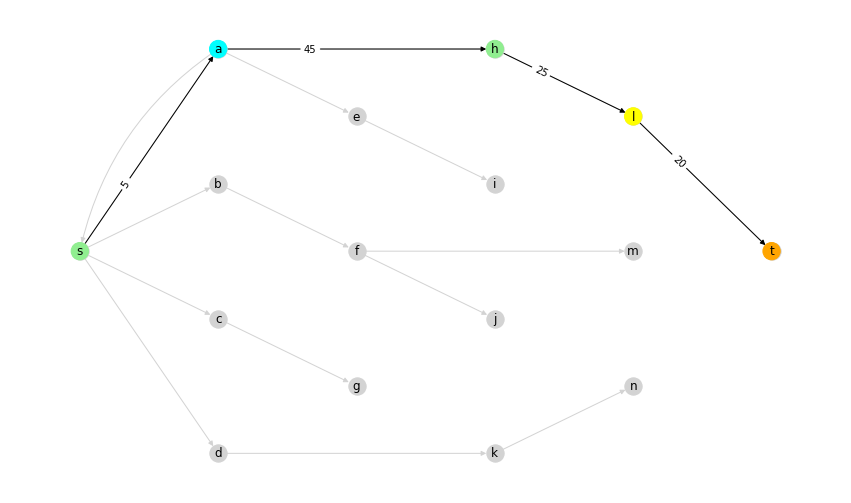

In [16]:
path, min_resid_flow = aug_path_dfs(parents, example_flow, "s", "t")

# Visualize
draw_level_network(R, parents, level, background=True)  # Level graph in the background
nc = [level_colors[level[n]] for n in path]
el = [(v, u) for u, v in nx.utils.pairwise(path)]
nx.draw(R, pos, nodelist=path, edgelist=el, node_color=nc, with_labels=True)
edgelabels = {(u, v): R[u][v]["capacity"] for u, v in el}
nx.draw_networkx_edge_labels(R, pos, edge_labels=edgelabels, label_pos=0.667);

Augmenting path after augmenting:

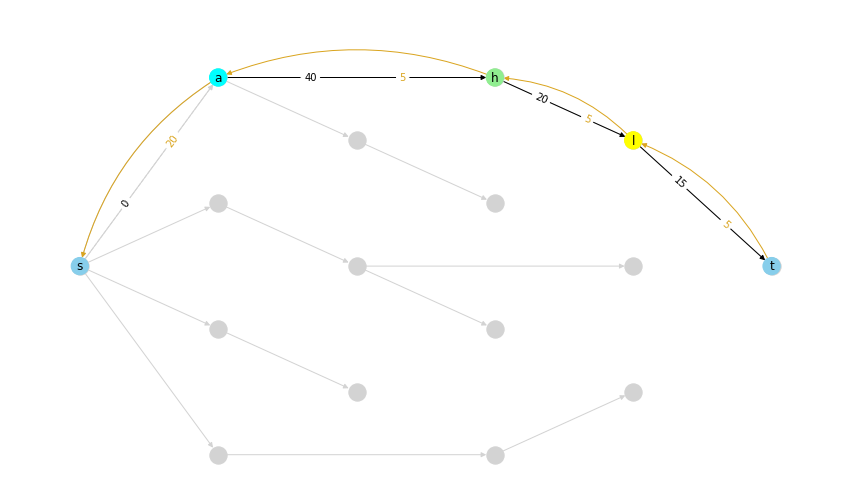

In [17]:
# Apply the minimum flow along the augmenting path
aug_flow = {(v, u): min_resid_flow for u, v in nx.utils.pairwise(path)}

# Visualize the augmented flow along the path
draw_level_network(R, parents, level, background=True)
aug_path = residual_graph(R.subgraph(path), aug_flow)

# Node ordering in the subgraph can be different than `path`
nodes = list(aug_path.nodes)
node_colors = [level_colors[level[n]] for n in nodes]
node_colors[nodes.index('s')] = node_colors[nodes.index('t')] = "skyblue"

draw_residual_graph(aug_path, ax=plt.gca())

Resulting new residual Network:

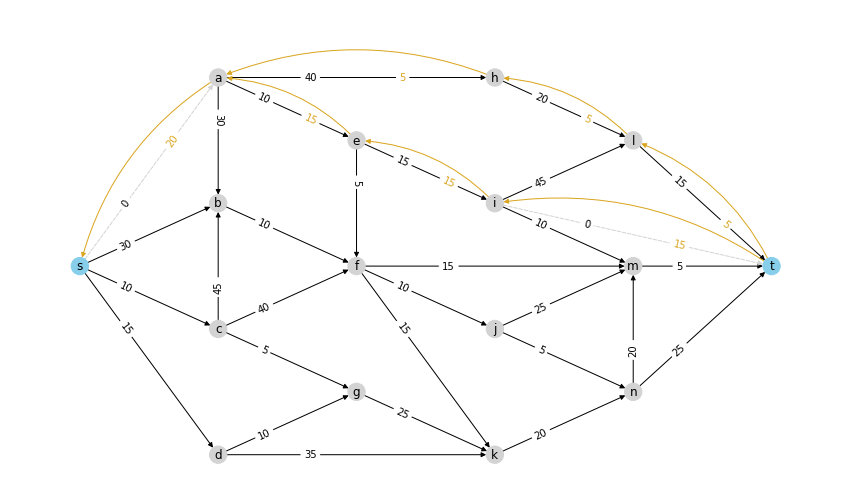

In [18]:
R = residual_graph(R, aug_flow)

# Original color scheme for residual graph
node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in R.nodes]
draw_residual_graph(R)

Each of the above steps plays a role in Dinitz's algorithm for finding the
maximum flow in a network, summarized below.

### Algorithm

1. Initialize a flow with zero value, $f_{uv}=0$
2. Construct a residual network  $N'$ from that flow
3. Find the level network $L$ using BFS, if $t$ is not in the level network then break and
output the flow
4. Find an augmenting path $P$ in level network $L$
5. Augment the flow along the edges of path $P$ which will give a new residual network
6. Repeat from point 3 with new residual network $N'$

## Maximum flow in NetworkX

In the previous section, we decomposed the Dinitz algorithm into smaller steps
to better understand the algorithm as a whole.
In practice however, there's no need to implement all these steps yourself!
NetworkX provides an implementation of Dinitz's algorithm:
[nx.flow.dinitz](https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.flow.dinitz.html).
`nx.flow.dinitz` includes several features in addition to those described above.
For example, the `cutoff` keyword argument can be used to prematurely terminate
the Dinitz algorithm once the desired flow value is reached.

Let's try out NetworkX's implementation of Dinitz's algorith on our example
network, `G`.

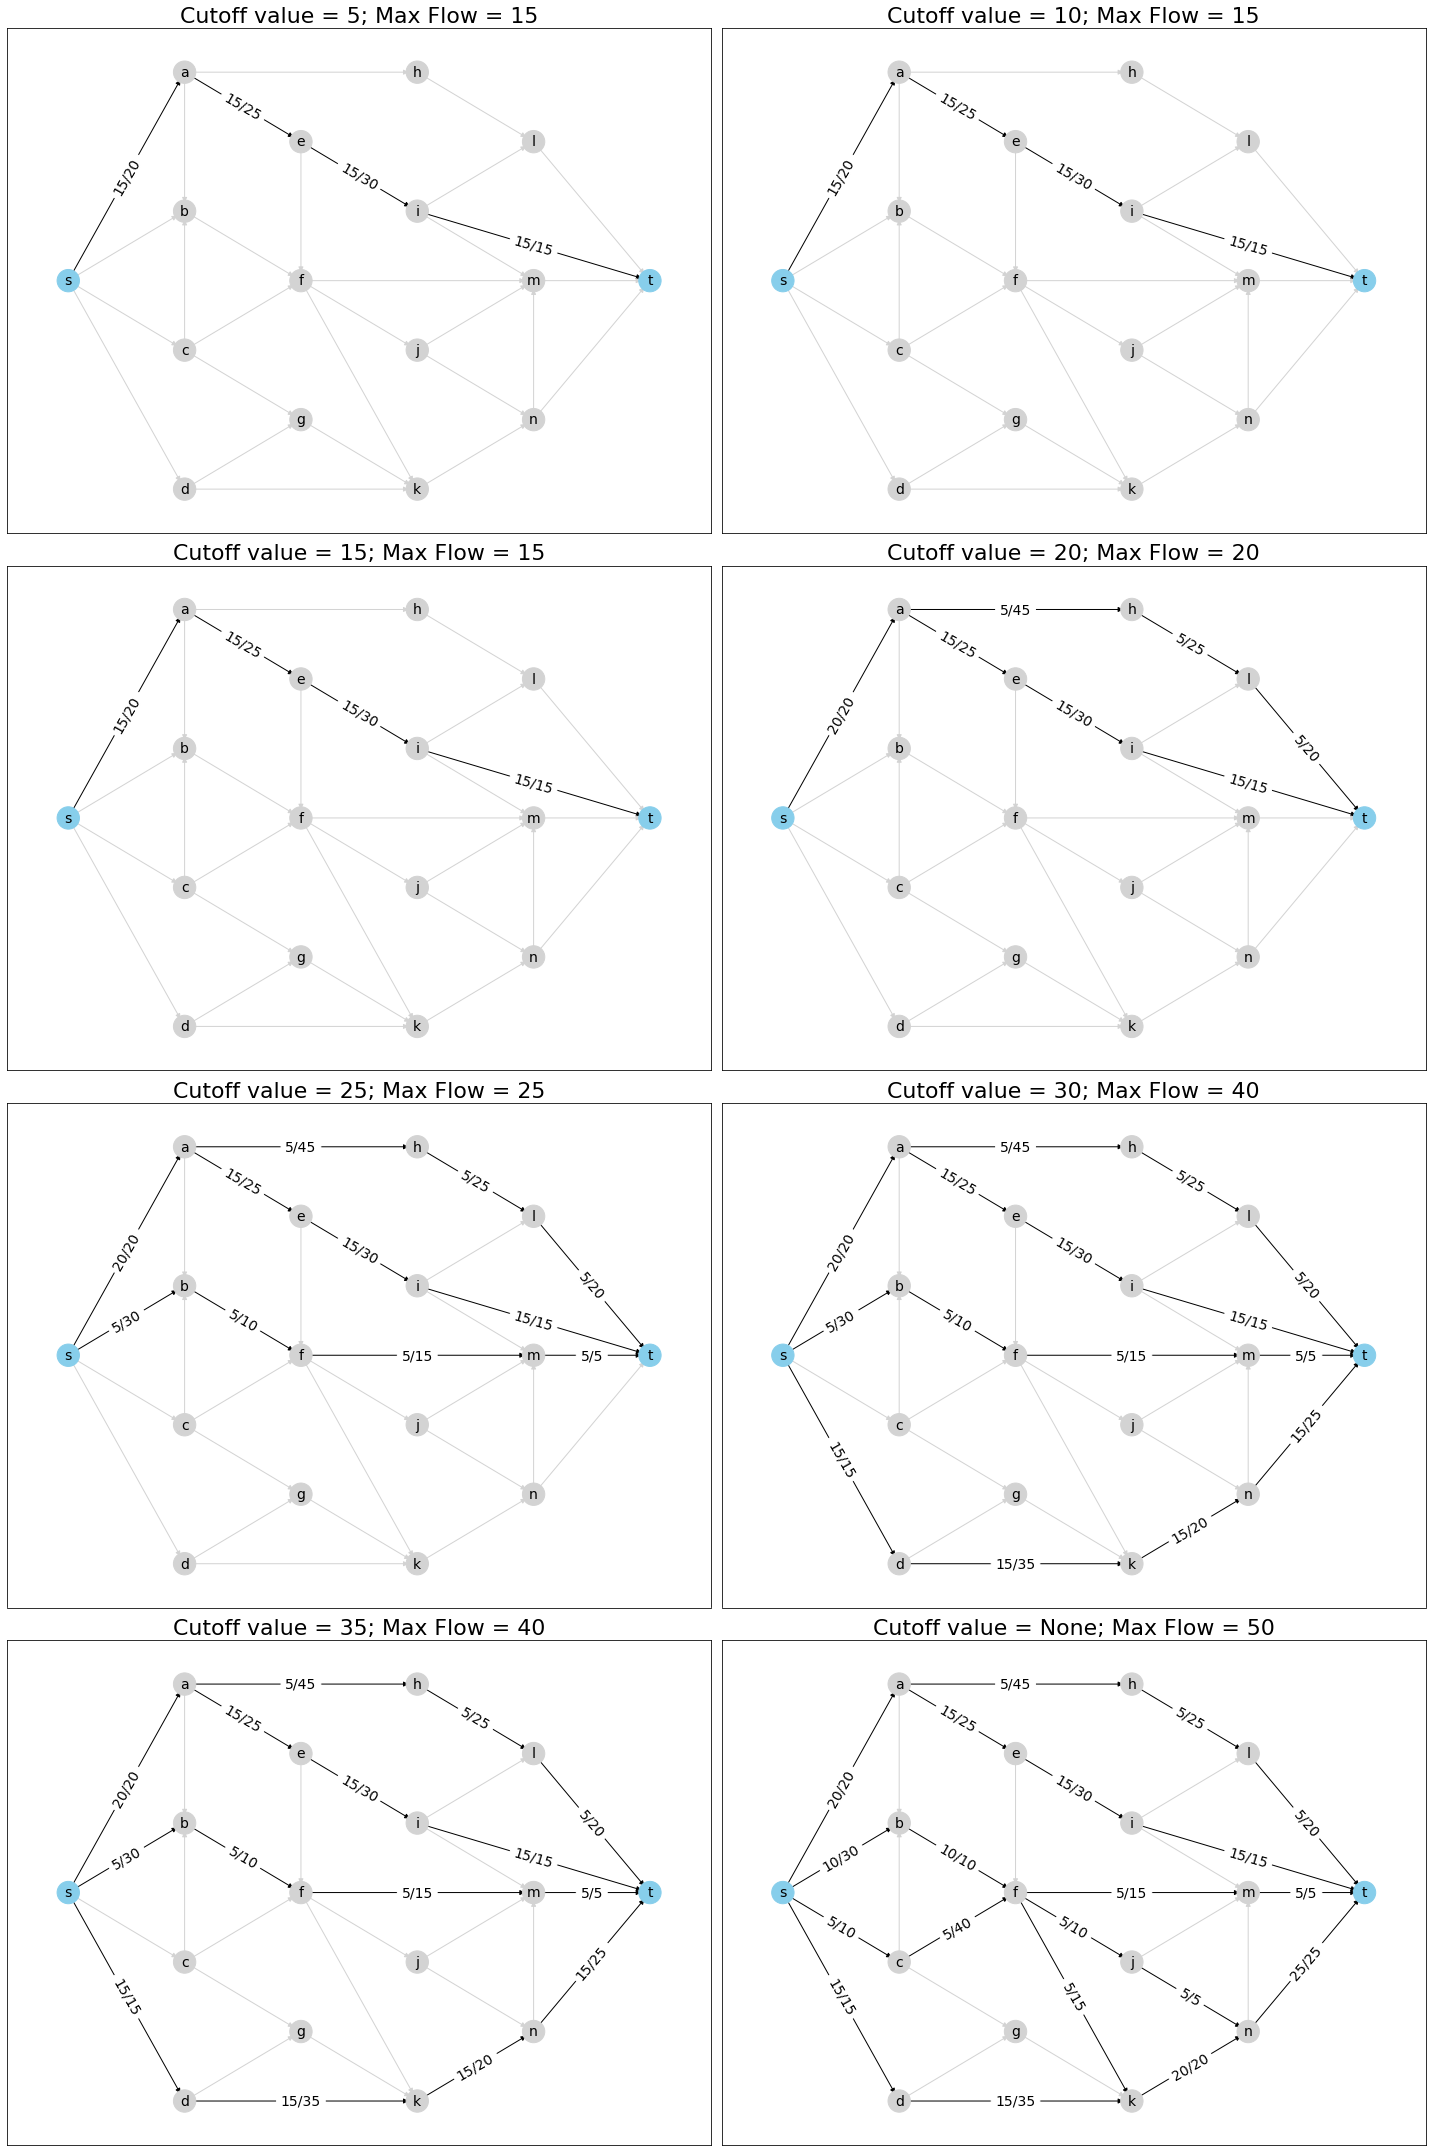

In [19]:
# Maximum flow values to find. Note the final value of `None` which indicates
# the algorithm should run to completion, finding the true maximum flow
cutoff_list = [5, 10, 15, 20, 25, 30, 35, None]

fig, axes = plt.subplots(4, 2, figsize=(20, 30))
node_colors = ["skyblue" if n in {"s", "t"} else "lightgray" for n in G.nodes]

for cutoff, ax in zip(cutoff_list, axes.ravel()):

    # calculating the maximum flow with the cutoff value
    R = nx.flow.dinitz(G, s="s", t="t", capacity="capacity", cutoff=cutoff)

    # coloring and labeling edges depending on if they have non-zero flow value or not
    edge_colors = [
        "lightgray" if R[u][v]["flow"] == 0 else "black" for u, v in G.edges
    ]
    edge_labels = {
        (u, v): f"{R[u][v]['flow']}/{G[u][v]['capacity']}"
        for u, v in G.edges
        if R[u][v]["flow"] != 0
    }

    # drawing the network
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size=500, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, ax=ax, font_size=14)
    nx.draw_networkx_edges(G, pos=pos, ax=ax, edge_color=edge_colors)
    nx.draw_networkx_edge_labels(
        G, pos=pos, ax=ax, edge_labels=edge_labels, font_size=14
    )
    ax.set_title(
        f"Cutoff value = {cutoff}; Max Flow = {R.graph['flow_value']}",
        size=22,
    )

fig.tight_layout()

Note: Iteration are stopped if the maximum flow found so far exceeds the cutoff value
## Reductions and Applications
There are many other problems which can be reduced to Maximum flow problem, for example:
* [Maximum Bipartite Matching](https://en.wikipedia.org/wiki/Matching_(graph_theory))
* [Assignment Problem](https://en.wikipedia.org/wiki/Assignment_problem)
* [Transportation Problem](https://en.wikipedia.org/wiki/Transportation_theory_(mathematics))

and many others.

Note that even though Dinitz works in $O(n^2m)$ strongly polynomial time, i.e. to say it
doesn't depend on the value of flow. It is noteworthy that its performance of bipartite
graphs is especially fast being $O(\sqrt n m)$ time, where $n = |V|$ & $m = |E|$.

Let's consider the example of shipping packages from warehouse to customers through some
intermediate shipping points, and we can only ship limited number of packages through
an intermediate shipping point in a day.

So how to assign intermediate shipping point to customer so that maximum number of
packages are shipped in a day?

![image:shipping problem eg](images/shipping-problem.png)

Number below each intermediate shipping point is the maximum number of shipping that
it can do in a day, and if edge connects an intermdiate shipping point and a customer
only then we can send the package from that shipping point to that customer.

Note that the warehouse node is named as $W$, intermediate shipping points as
$lw1, lw2, lw3$, and customers as $c1,c2...c20$.

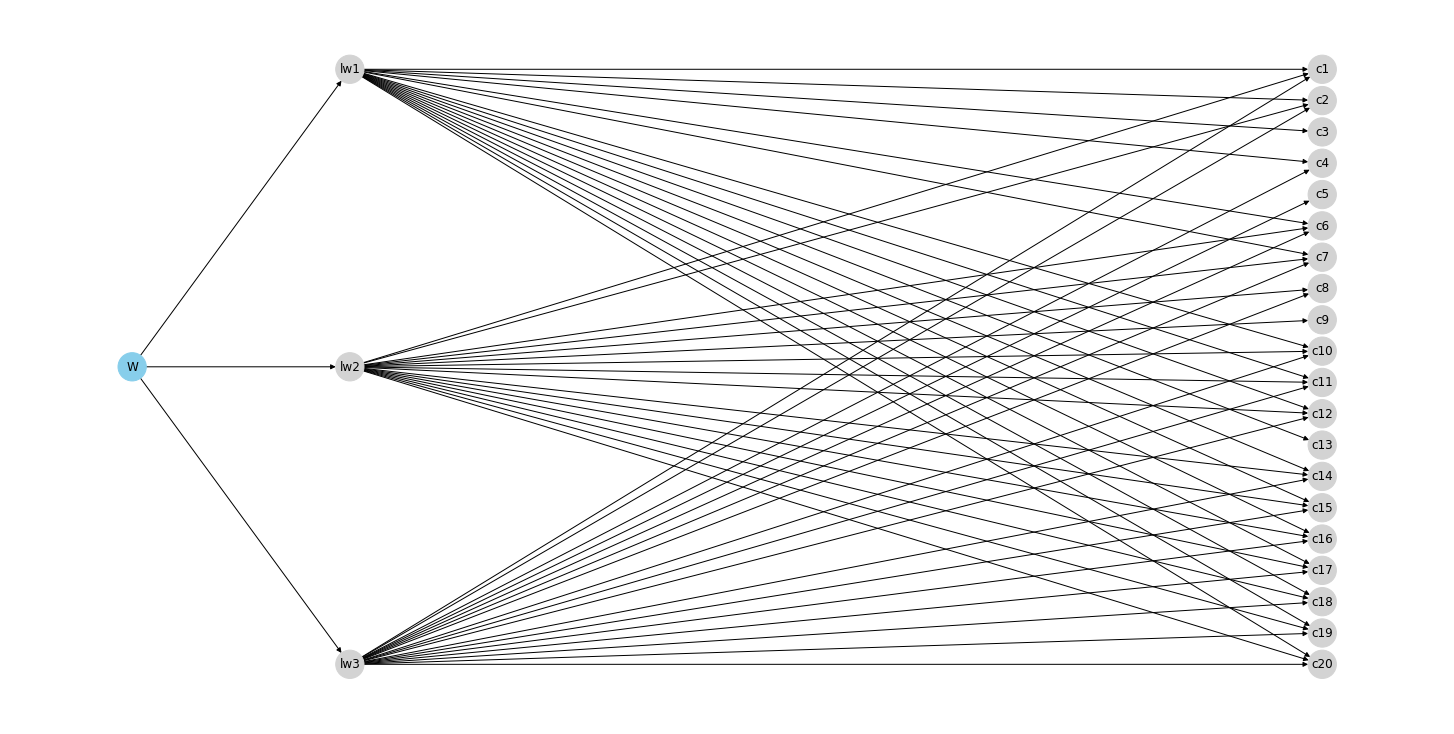

In [20]:
# Load data
B = nx.read_gml("data/shipping_graph.gml")
pos = {k: np.asarray(v) for k, v in B.nodes(data="pos")}

# drawing the loaded graph
node_colors = ["skyblue" if u == "W" else "lightgray" for u in B.nodes]
plt.figure(figsize=(20, 10))
nx.draw(
    B, pos=pos, node_color=node_colors, with_labels=True, arrowsize=10, node_size=800
)

In [21]:
# maximum shipping capacities
{u: B.nodes[u]["maximum_shippings"] for u in ["lw1", "lw2", "lw3"]}

{'lw1': 8, 'lw2': 5, 'lw3': 6}

Let's add a pseudo node $T$ denoting the ultimate sink node and add edges from
$ci \to T$, $i\in\{1,2,...,20\}$. Note that shipping any more than the maximum
number of packages that any of $lwi$, $i\in\{1,2,3\}$ can ship on that day is useless.
So we can transfer that maximum number of shipping to a maximum capacity of the
edges $W\to lwi$, $i\in\{1,2,3\}$ and for all other edges, we can assign its capacity
as 1 we only need to do one shipment per customer.

Note: We have already assigned the position to node $T$ in `pos` which was loaded earlier.

In [22]:
# adding node T and edges to T from c1,c2,...c20
B.add_node("T")
pos["T"] = np.array([0.97, 0.0])
B.add_edges_from((f"c{i}", "T") for i in range(1, 21))

# adding capacities from W to lw1, lw2, lw3
for u in ["lw1", "lw2", "lw3"]:
    B["W"][u]["capacity"] = B.nodes[u]["maximum_shippings"]

# adding capacities as 1 for all other edges except edges from W
for u, v in B.edges:
    if u != "W":
        B[u][v]["capacity"] = 1

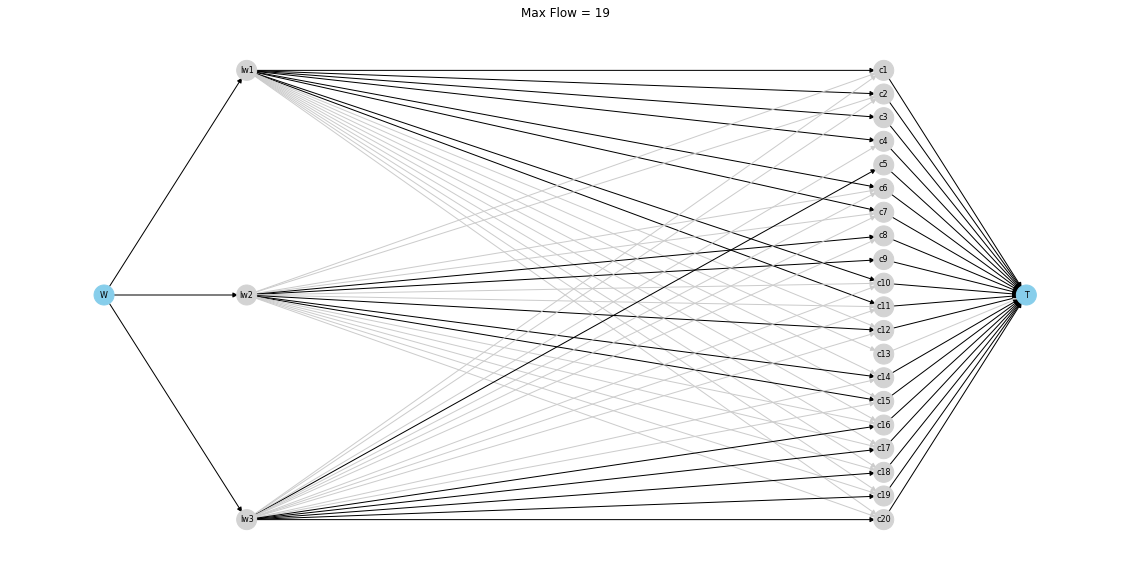

In [23]:
# assign colors and labels to nodes based on their type
node_colors = ["skyblue" if u in {"W", "T"} else "lightgray" for u in B.nodes]

# calculating the maximum flow with the cutoff value
R = nx.flow.dinitz(B, s="W", t="T", capacity="capacity")

# coloring and labeling edges depending on if they have non-zero flow value or not
edge_colors = ["0.8" if R[u][v]["flow"] == 0 else "0" for u, v in B.edges]

# drawing the network
plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(B, pos=pos, node_size=400, node_color=node_colors)
nx.draw_networkx_labels(B, pos=pos, font_size=8)
nx.draw_networkx_edges(B, pos=pos, edge_color=edge_colors)
plt.title(f"Max Flow = {R.graph['flow_value']}", size=12)
plt.axis("off")
plt.show()

Above we can see a matching of intermediate shipping points and customers which
gives the maximum shipping in a day.

## References
[^1]: Dinitz' Algorithm: The Original Version and Even's Version. 2006. Yefim Dinitz.
In Theoretical Computer Science. Lecture Notes in Computer Science.
Volume 3895. pp 218-240. <https://doi.org/10.1007/11685654_10>